In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths

In [27]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=2, root=root, verbose=True)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-19-2021_1224_16/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recs', 'voxel_recs', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])


In [7]:
out['models'].shape

(875, 3)

In [8]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [10]:
st_enc_wts = out['best_params'][1][:,:,0]
st_enc_wts.shape

(19738, 150)

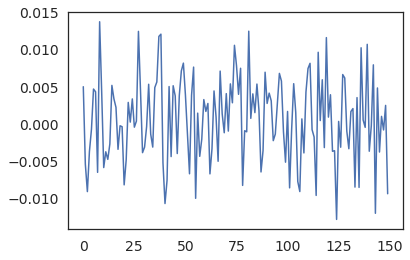

In [12]:
plt.figure();
plt.plot(np.mean(st_enc_wts, axis=0))

Text(0.5, 1.0, 'Sketch tokens')

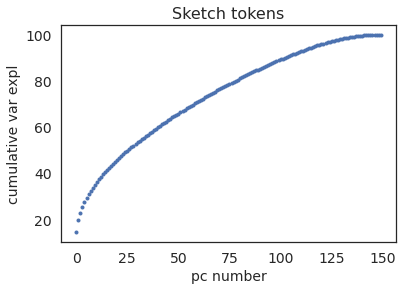

In [28]:
from sklearn import decomposition
n_trials = st_enc_wts.shape[0]
n_comp = st_enc_wts.shape[1]
pca = decomposition.PCA(n_components = n_comp, copy=True)
pca.fit(st_enc_wts)     
scores_st = pca.transform(st_enc_wts)

st_pca_wts = pca.components_
ev = pca.explained_variance_
st_ev = ev/np.sum(ev)*100
pre_mean = pca.mean_

plt.figure();
# plt.plot(ev,'.')
plt.plot(np.cumsum(st_ev),'.')
plt.xlabel('pc number')
plt.ylabel('cumulative var expl')
plt.title('Sketch tokens')

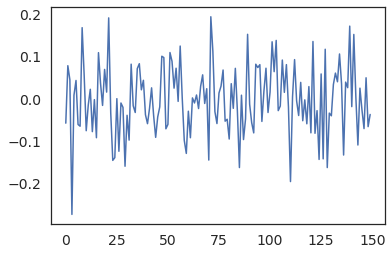

In [14]:
plt.figure();
pca_wts = st_pca_wts
plt.plot(pca_wts[0,:])

In [15]:
from utils import default_paths
sketch_token_feat_path = default_paths.sketch_token_feat_path
    
discr_types = ['animacy', 'indoor_outdoor','person','animal','vehicle','food']
lda_wts = []
for di, dt in enumerate(discr_types):

    lda_features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                              'S%d_LDA_%s.npy'%(subject, dt))
    print('loading from %s'%lda_features_file)
    # loading pre-computed linear discriminant analysis features
    lda_result = np.load(lda_features_file, allow_pickle=True).item()
   
    lda_wts.append(lda_result['wts'])

loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_animacy.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_indoor_outdoor.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_person.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_animal.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_vehicle.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_LDA_food.npy


In [16]:
best_prf_index = out1['best_params'][5]
n_voxels = st_enc_wts.shape[0]
n_discr_types = len(lda_wts)

lda_dotprod = np.zeros((n_voxels,n_discr_types))
lda_angle = np.zeros((n_voxels,n_discr_types))

for di in range(n_discr_types):
    lda_wts_each_prf = lda_wts[di]
    for vv in range(n_voxels):

        lda_axis = np.squeeze(lda_wts_each_prf[best_prf_index[vv,0]])
        dp = lda_axis @ st_enc_wts[vv,:]
        lda_dotprod[vv,di] = dp
        cosangle = dp / (np.sqrt(np.sum(lda_axis**2)) * np.sqrt(np.sum(st_enc_wts[vv,:]**2)))
        lda_angle[vv,di] = np.arccos(cosangle) * 180/np.pi

129.4621833921564


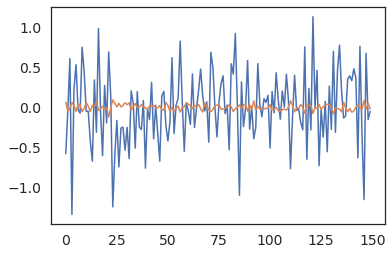

In [17]:
plt.figure();
di = 0
vv2plot = np.argmax(lda_angle[:,0])
animacy_axis = np.squeeze(lda_wts[0][best_prf_index[vv2plot,0]])

plt.plot(animacy_axis)
plt.plot(st_enc_wts[vv2plot,:])
print(lda_angle[vv2plot,0])

42.414902428986686


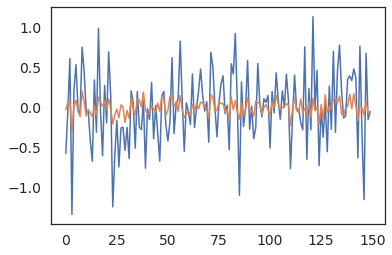

In [37]:
plt.figure();
di = 0
vv2plot = np.argmin(lda_angle[:,0])
animacy_axis = np.squeeze(lda_wts[0][best_prf_index[vv2plot,0]])
plt.plot(animacy_axis)
plt.plot(st_enc_wts[vv2plot,:])
print(lda_angle[vv2plot,0])

In [36]:

out = out1
best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

port=33333

names0 = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps0 = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps0 = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins0 = [0,0,0]
maxes0 = [7, 360, 4]

npc2plot=3
maps1 = [scores_st[:,pc].astype('float64') for pc in range(npc2plot)]
names1 = ['PCA on weights: pc %d score'%pc for pc in range(npc2plot)]

cmaps1 = ['RdBu' for pc in range(npc2plot)]
mins1 = list(-np.max(np.abs(scores_st[:,0:npc2plot]), axis=0).astype(float))
maxes1 = list(np.max(np.abs(scores_st[:,0:npc2plot]), axis=0).astype(float))

maps2 = [lda_angle[:,di] for di in range(n_discr_types)]
names2 = ['angle bw wts and %s axis'%discr_types[di] for di in range(n_discr_types)]

cmaps2 = ['PuBu' for di in range(n_discr_types)]
mins2 = [0 for di in range(n_discr_types)]
maxes2 = [180 for di in range(n_discr_types)]

names3 = ['R2: %s'%fitting_type for fitting_type in fitting_types]
maps3 = subspace_r2s
bad_voxels = np.all(np.concatenate(maps3, axis=1)<0, axis=1)
for vals in maps3:
    vals[bad_voxels] = np.nan
maps3 = [np.sqrt(np.squeeze(m)) for m in maps3]

cmaps3 = ['PuBu' for ff in range(len(fitting_types))]
mins3 = [0 for ff in range(len(fitting_types))]
maxes3 = [0.6 for ff in range(len(fitting_types))]


# maps = maps0+maps1
# cmaps=cmaps0+cmaps1
# names=names0+names1
# mins=mins0+mins1
# maxes=maxes0+maxes1

maps = maps0+maps1+maps2+maps3
cmaps=cmaps0+cmaps1+cmaps2+cmaps3
names=names0+names1+names2+names3
mins=mins0+mins1+mins2+mins3
maxes=maxes0+maxes1+maxes2+maxes3

plot_utils.plot_maps_pycortex(maps, names, subject, out, 'pca', roi_def=roi_def, port=port, \
                              cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [38]:
out['zscore_in_groups']

True

In [31]:
subject = 1
volume_space=True
root = os.path.dirname(os.path.dirname(os.getcwd()))

fitting_types = ['sketch_tokens', \
                 'sketch_tokens_pca_max1dim', 'sketch_tokens_pca_max11dim', \
                 'sketch_tokens_lda_all_supcat','sketch_tokens_lda_animacy', 
                 'sketch_tokens_lda_person','sketch_tokens_lda_animal', \
                 'sketch_tokens_lda_vehicle','sketch_tokens_lda_food']

subspace_r2s = []
ns = [2,0,0,0,0,0,0,0,0]
for fi, fitting_type in enumerate(fitting_types):
    
    print(fitting_type)
    print(ns[fi])
    out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, \
                                    fitting_type, n_from_end=ns[fi], root=root, verbose=True);
    print(out['zscore_in_groups'])
    subspace_r2s.append(out['val_r2'][:,0:1])
    print('\n')

sketch_tokens
2
loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-19-2021_1224_16/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recs', 'voxel_recs', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])
False


sketch_tokens_pca_max1dim
0
loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens_pca_max1dim/Oct-19-2021_1112_00/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_n

In [32]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
clusters = clust['clusters']['clusters'][0][0]

Text(0.5, 0.98, 'Sketch token features with highest weights for encoding model wts PC 0')

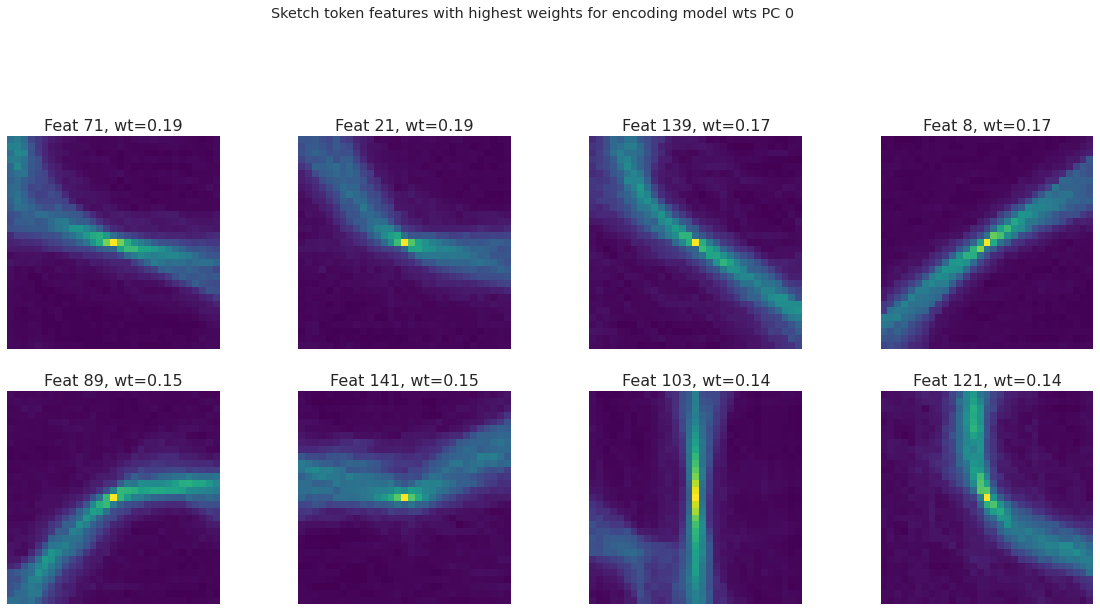

In [38]:
nclusters = clusters.shape[2]
n2plot = 8
npx = 4; npy = 4;
pc2plot = 0
w = pca_wts[pc2plot,:]

clusters2plot = np.flip(np.argsort(w))[0:n2plot]

plt.figure(figsize=(20,18))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(npx,npy,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with highest weights for encoding model wts PC %d'%pc2plot)

Text(0.5, 0.98, 'Sketch token features with lowest weights for encoding model wts PC 0')

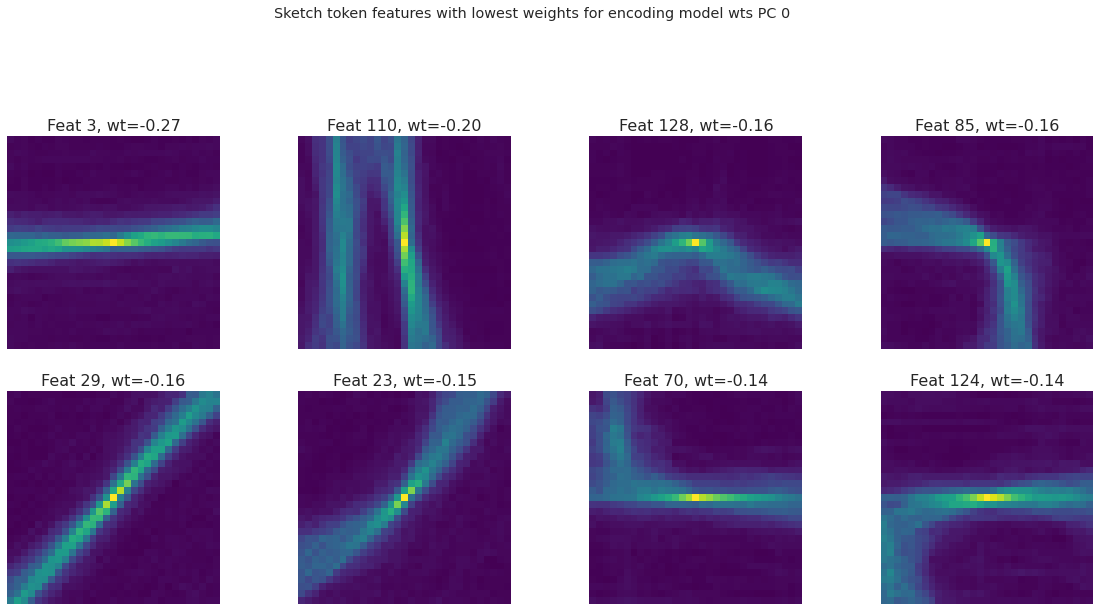

In [40]:
nclusters = clusters.shape[2]
n2plot = 8
npx = 4; npy = 4;
pc2plot = 0
w = pca_wts[pc2plot,:]

clusters2plot = np.argsort(w)[0:n2plot]

plt.figure(figsize=(20,18))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(npx,npy,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with lowest weights for encoding model wts PC %d'%pc2plot)

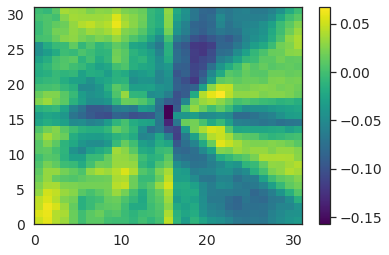

In [35]:
weighted_cluster = np.tensordot(clusters, pca_wts[0,0:150], axes=[2,0])
weighted_cluster.shape
plt.figure();
plt.pcolormesh(weighted_cluster);
plt.colorbar()